Identified 5 common core words to exclude based on threshold 1.0% (lemmatized):
['one', 'rabbi', 'rav', 'said', 'say'] ...

--- Generating Word Clouds ---
Generating word clouds *excluding* words common to all translation sets (human + LLM).
Words excluded due to high commonality (>1.0% frequency): 5 words.
Word cloud saved to: word_clouds\Overall_Human_Translations_Unique_Focus_wordcloud.png
Word cloud saved to: word_clouds\Overall_GPT35Turbo_Translations_Unique_Focus_wordcloud.png
Word cloud saved to: word_clouds\Overall_Llama_3_Translations_Unique_Focus_wordcloud.png
Word cloud saved to: word_clouds\Overall_Uncensored_Model_Translations_Unique_Focus_wordcloud.png

Comparison report saved to: 'llm_talmud_translation_comparison_report_20250821_123848.txt'
Please review the report for detailed analysis and check the 'word_clouds' directory for images.

--- Generating Visualizations ---


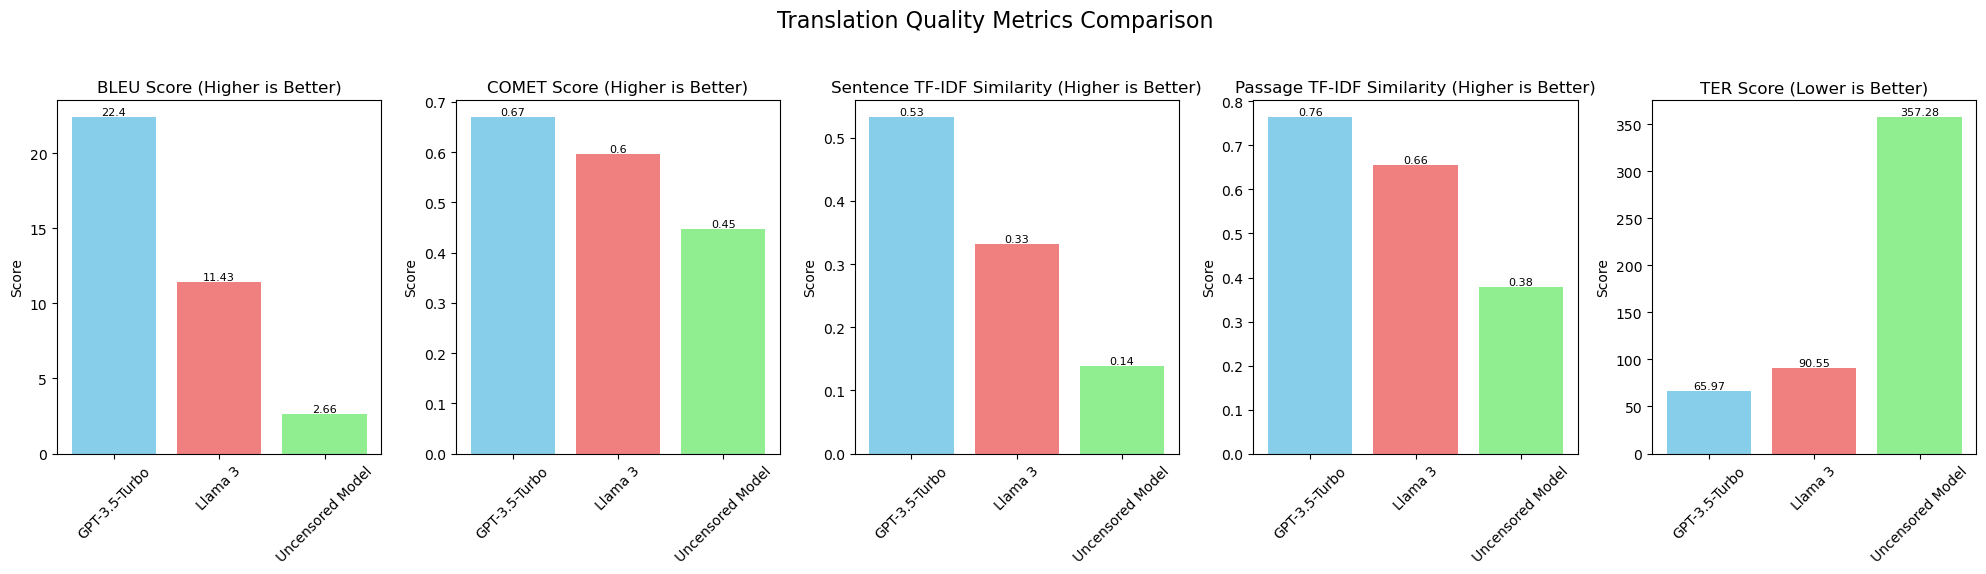

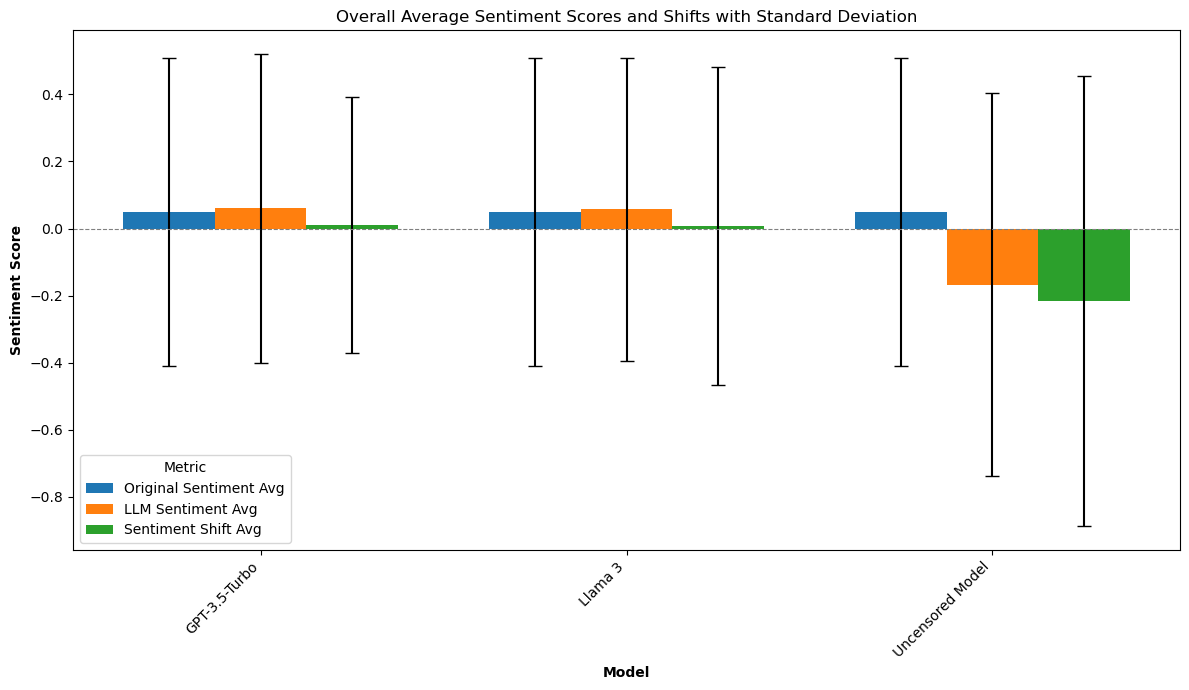

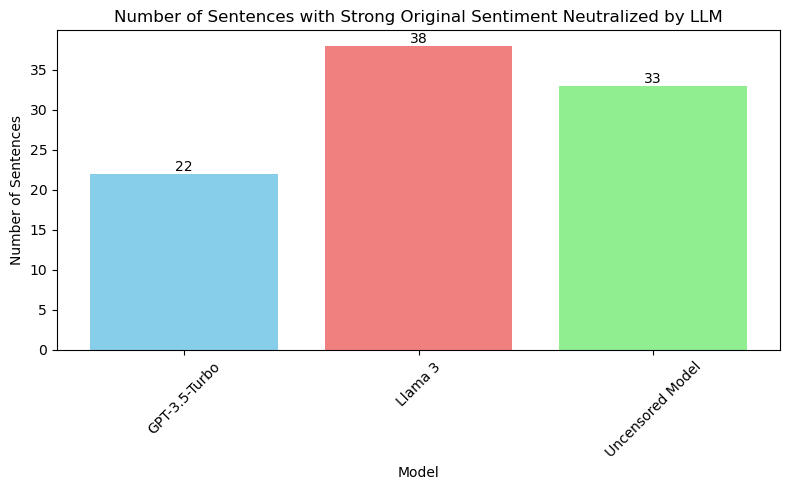

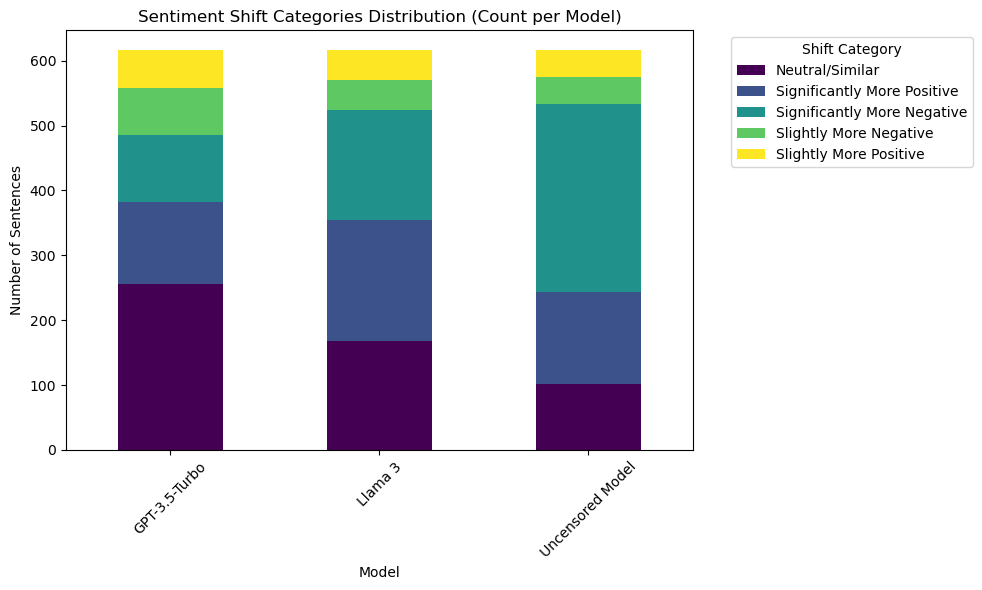

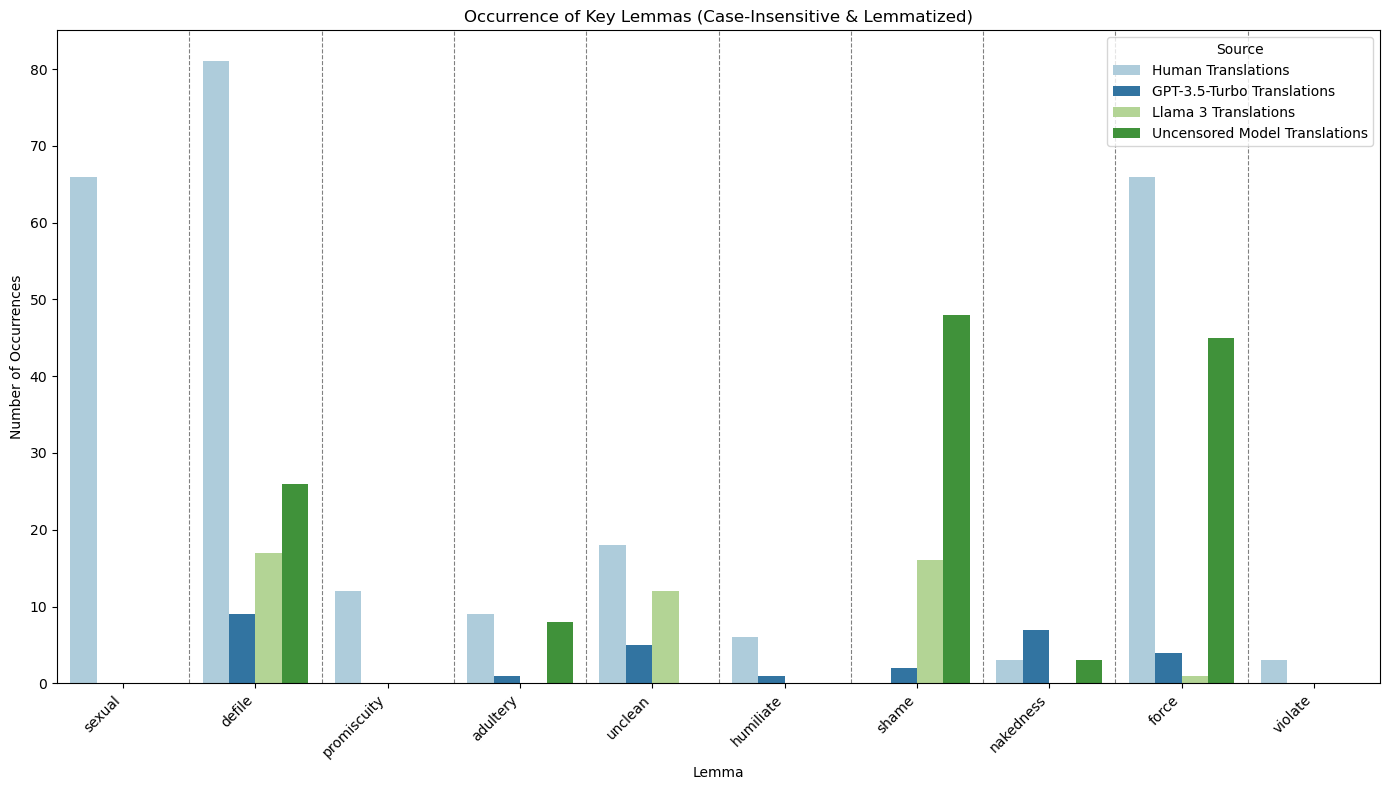

C:\Users\miria\AppData\Local\Temp\ipykernel_14192\1430774954.py:514: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Original Tag', y=metric, data=model_df, ax=ax, palette='coolwarm')
C:\Users\miria\AppData\Local\Temp\ipykernel_14192\1430774954.py:514: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Original Tag', y=metric, data=model_df, ax=ax, palette='coolwarm')
C:\Users\miria\AppData\Local\Temp\ipykernel_14192\1430774954.py:514: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Original Tag', y=metric, data=model_df, ax=ax, palette='coo

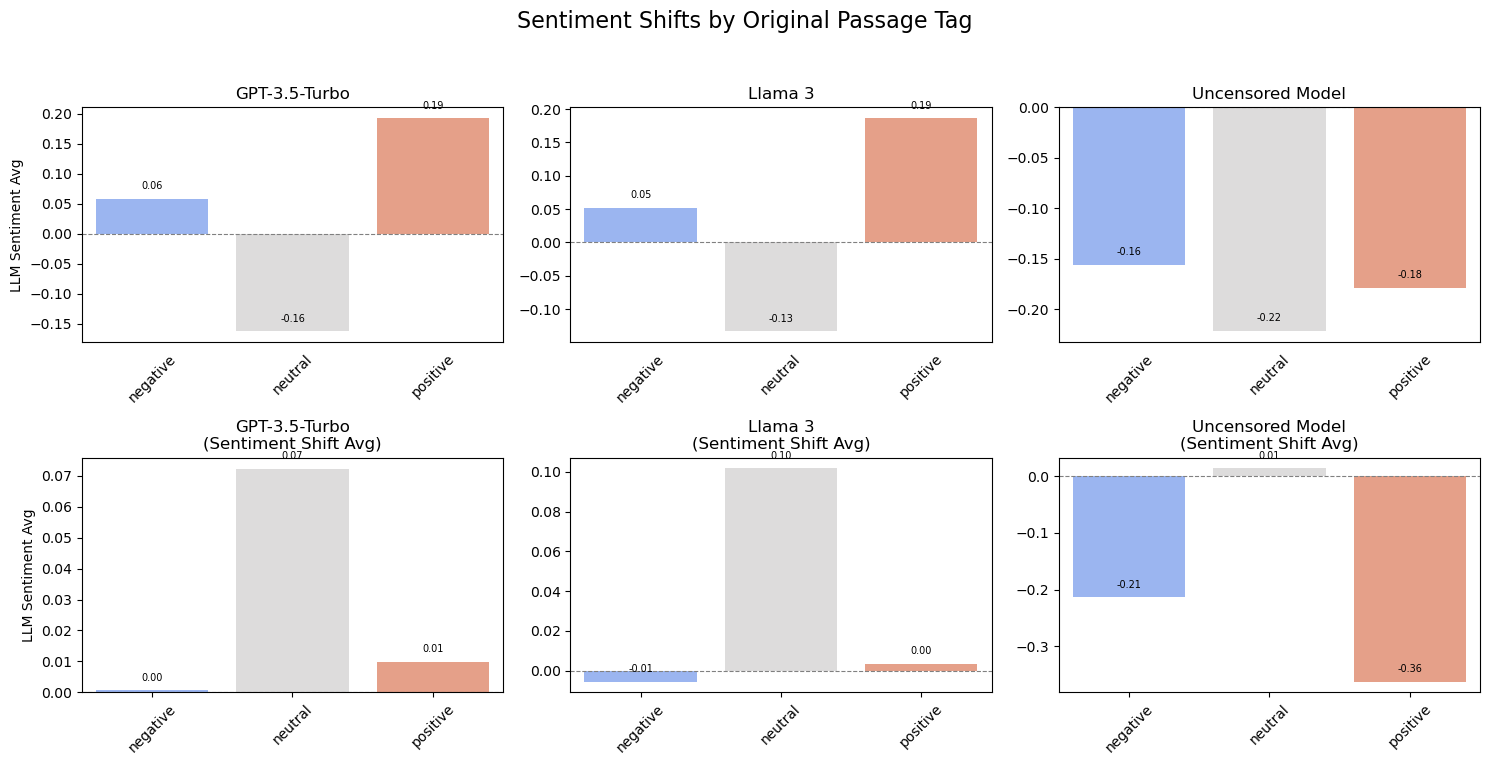

Visualizations saved as PNG files in the current directory.


In [6]:
import json
import os
import pandas as pd
from datetime import datetime
from collections import defaultdict, Counter
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# Initialize the WordNet Lemmatizer globally
lemmatizer = WordNetLemmatizer()
# --- Configuration for Smoothing Criteria (used for identifying examples) ---
STRONG_SENTIMENT_THRESHOLD = 0.5
NEUTRAL_SENTIMENT_THRESHOLD = 0.1
# --- Function to generate and save a word cloud (unchanged) ---
def generate_word_cloud(text, title, output_dir="word_clouds", max_words=100, words_to_exclude=None):
    """
    Generates a word cloud from the given text and saves it as a PNG image.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    current_stopwords = set(STOPWORDS)
    current_stopwords.update(stopwords.words('english'))
    if words_to_exclude:
        current_stopwords.update(words_to_exclude)
    word_tokens = word_tokenize(cleaned_text)
    filtered_words = [word for word in word_tokens if word not in current_stopwords and len(word) > 1]
    processed_text = " ".join(filtered_words)
    if not processed_text.strip():
        print(f"Warning: No meaningful words left for word cloud '{title}' after preprocessing.")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=current_stopwords, max_words=max_words).generate(processed_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    filename_title = "".join([c for c in title if c.isalnum() or c in (' ', '_')]).rstrip()
    filename_title = filename_title.replace(" ", "_")
    output_path = os.path.join(output_dir, f"{filename_title}_wordcloud.png")
    plt.savefig(output_path)
    plt.close()
    print(f"Word cloud saved to: {output_path}")
# --- Function to load and extract metrics from a single results file (unchanged) ---
def extract_model_metrics(results_filepath, model_name):
    """
    Loads a results JSON file and extracts aggregate and sentiment metrics.
    """
    try:
        with open(results_filepath, 'r', encoding='utf-8') as f:
            results = json.load(f)
    except FileNotFoundError:
        print(f"Error: Results file not found at '{results_filepath}' for {model_name}.")
        return None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from '{results_filepath}' for {model_name}.")
        return None
    all_sentence_data = []
    smoothed_sentences_identified = []
    all_original_sentences_map = {}
    for passage_key, passage_data in results['passages'].items():
        passage_ref = passage_data['metadata'].get('ref', 'N/A')
        original_passage_sentiment_tag = passage_data['metadata'].get('sentiment', 'unknown')
        for idx, sentence in enumerate(passage_data['sentences']):
            sentence_data_copy = sentence.copy()
            sentence_data_copy['model_name'] = model_name
            sentence_data_copy['passage_key'] = passage_key
            sentence_data_copy['passage_ref'] = passage_ref
            sentence_data_copy['sentence_index'] = idx
            sentence_data_copy['original_passage_sentiment_tag'] = original_passage_sentiment_tag
            all_sentence_data.append(sentence_data_copy)
            original_compound = sentence['original_sentiment']['compound']
            llm_compound = sentence['llm_sentiment']['compound']
            if (abs(original_compound) >= STRONG_SENTIMENT_THRESHOLD and abs(llm_compound) < NEUTRAL_SENTIMENT_THRESHOLD):
                sentiment_reduction_magnitude = abs(original_compound) - abs(llm_compound)
                smoothed_sentences_identified.append({
                    'passage_ref': passage_ref,
                    'sentence_index': idx,
                    'hebrew_text': sentence['text'],
                    'human_translation': sentence['human_translation'],
                    'llm_translation': sentence['llm_translation'],
                    'original_sentiment': original_compound,
                    'llm_sentiment': llm_compound,
                    'smoothing_magnitude': sentiment_reduction_magnitude
                })
        all_original_sentences_map[(passage_ref, idx)] = sentence['text']
    df = pd.DataFrame(all_sentence_data)
    aggregate_metrics = {
        'model_name': model_name,
        'bleu_score_avg': df['bleu_score'].mean() if not df.empty else np.nan,
        'bleu_score_std': df['bleu_score'].std() if not df.empty else np.nan,
        'ter_score_avg': df['ter_score'].mean() if not df.empty else np.nan,
        'ter_score_std': df['ter_score'].std() if not df.empty else np.nan,
        'comet_score_avg': df['comet_score'].mean() if not df.empty else np.nan,
        'comet_score_std': df['comet_score'].std() if not df.empty else np.nan,
        'sentence_tfidf_similarity_avg': df['similarity_score'].mean() if not df.empty else np.nan,
        'sentence_tfidf_similarity_std': df['similarity_score'].std() if not df.empty else np.nan,
    }
    passage_similarity_scores = [p['passage'].get('similarity_score', np.nan) for p in results['passages'].values()]
    aggregate_metrics['passage_tfidf_similarity_avg'] = np.nanmean(passage_similarity_scores) if passage_similarity_scores else np.nan
    aggregate_metrics['passage_tfidf_similarity_std'] = np.nanstd(passage_similarity_scores) if passage_similarity_scores else np.nan
    original_compound_scores = df['original_sentiment'].apply(lambda x: x['compound'])
    llm_compound_scores = df['llm_sentiment'].apply(lambda x: x['compound'])
    sentiment_metrics = {
        'original_sentiment_avg': original_compound_scores.mean() if not df.empty else np.nan,
        'llm_sentiment_avg': llm_compound_scores.mean() if not df.empty else np.nan,
        'sentiment_shift_avg': (llm_compound_scores - original_compound_scores).mean() if not df.empty else np.nan,
        'num_neutralized_sentences': len(smoothed_sentences_identified)
    }
    def classify_sentiment_shift(shift):
        if shift > 0.2:
            return "Significantly More Positive"
        elif shift > 0.05:
            return "Slightly More Positive"
        elif shift < -0.2:
            return "Significantly More Negative"
        elif shift < -0.05:
            return "Slightly More Negative"
        else:
            return "Neutral/Similar"
    if not df.empty:
        df['sentiment_shift'] = llm_compound_scores - original_compound_scores
        sentiment_categories = df['sentiment_shift'].apply(classify_sentiment_shift).value_counts().to_dict()
    else:
        sentiment_categories = {}
    sentiment_metrics['sentiment_shift_categories'] = sentiment_categories
    return {
        'model_name': model_name,
        'aggregate_metrics': aggregate_metrics,
        'sentiment_metrics': sentiment_metrics,
        'all_sentences_df': df,
        'smoothed_sentences': sorted(smoothed_sentences_identified, key=lambda x: x['smoothing_magnitude'], reverse=True),
        'original_sentences_map': all_original_sentences_map
    }
# --- Function to count specific word occurrences with lemmatization (unchanged) ---
def count_word_occurrences(text_list, target_word):
    """
    Counts the total occurrences of a target word (case-insensitively, lemmatized) across a list of strings.
    """
    count = 0
    target_word_lower = target_word.lower()
    target_lemma_verb = lemmatizer.lemmatize(target_word_lower, pos=wordnet.VERB)
    target_lemma_noun = lemmatizer.lemmatize(target_word_lower, pos=wordnet.NOUN)
    for text in text_list:
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
        words = word_tokenize(cleaned_text)
        lemmatized_words_verb = [lemmatizer.lemmatize(w, pos=wordnet.VERB) for w in words]
        lemmatized_words_noun = [lemmatizer.lemmatize(w, pos=wordnet.NOUN) for w in words]
        count += lemmatized_words_verb.count(target_lemma_verb)
        if target_lemma_noun != target_lemma_verb:
            count += lemmatized_words_noun.count(target_lemma_noun)
    return count
# --- Main comparison function (MODIFIED to return DataFrames and sentiment std) ---
def compare_llm_translation_results(model_data_configs, output_filename="llm_comparison_report.txt", common_words_threshold=0.01):
    """
    Compares the translation performance metrics of multiple LLMs and outputs a detailed report.
    Also generates word clouds for overall human and LLM translations, with an option to exclude commonly used words across all corpora.
    Includes a check for specific word occurrences.
    Returns:
    tuple: (agg_df, sentiment_df, sentiment_std_df, df_sentiment_categories_expanded, df_specific_words_plot, df_sentiment_by_tag_plot)
    containing DataFrames ready for plotting.
    """
    all_model_metrics = []
    all_dfs = []
    common_problem_sentence_ids = set()
    all_human_translations_text = []
    all_llm_translations_text = defaultdict(list)
    all_combined_translations_text = []
    for config in model_data_configs:
        metrics = extract_model_metrics(config['path'], config['name'])
        if metrics:
            all_model_metrics.append(metrics)
            all_dfs.append(metrics['all_sentences_df'])
            for s_data in metrics['smoothed_sentences'][:5]:
                common_problem_sentence_ids.add((s_data['passage_ref'], s_data['sentence_index']))
            if not metrics['all_sentences_df'].empty:
                current_human_translations = metrics['all_sentences_df']['human_translation'].tolist()
                current_llm_translations = metrics['all_sentences_df']['llm_translation'].tolist()
                all_human_translations_text.extend(current_human_translations)
                all_llm_translations_text[config['name']].extend(current_llm_translations)
                all_combined_translations_text.extend(current_human_translations)
                all_combined_translations_text.extend(current_llm_translations)
    if not all_model_metrics:
        print("No valid model data was loaded. Aborting comparison.")
        return None, None, None, None, None, None
    # --- Determine Common Core Words for Exclusion ---
    common_core_words_to_exclude = set()
    if all_combined_translations_text:
        full_text_combined = " ".join(all_combined_translations_text)
        cleaned_full_text = re.sub(r'[^a-zA-Z\s]', '', full_text_combined).lower()
        word_tokens_combined = word_tokenize(cleaned_full_text)
        standard_stopwords = set(STOPWORDS)
        standard_stopwords.update(stopwords.words('english'))
        lemmatized_filtered_words_combined = [
            lemmatizer.lemmatize(w, pos=wordnet.VERB) for w in word_tokens_combined if w not in standard_stopwords and len(w) > 1
        ]
        lemmatized_filtered_words_combined.extend([
            lemmatizer.lemmatize(w, pos=wordnet.NOUN) for w in word_tokens_combined if w not in standard_stopwords and len(w) > 1
        ])
        word_counts = Counter(lemmatized_filtered_words_combined)
        total_words = sum(word_counts.values())
        if total_words > 0:
            for word, count in word_counts.items():
                if count / total_words >= common_words_threshold:
                    common_core_words_to_exclude.add(word)
            print(f"Identified {len(common_core_words_to_exclude)} common core words to exclude based on threshold {common_words_threshold*100}% (lemmatized):")
            print(sorted(list(common_core_words_to_exclude))[:20], "...")
        else:
            print("No words found in combined text for common word analysis.")
    agg_data = []
    sentiment_data = []
    sentiment_std_data = []
    for m in all_model_metrics:
        # Calculate standard deviations for sentiment metrics
        df_model = m['all_sentences_df']
        original_compound_scores = df_model['original_sentiment'].apply(lambda x: x['compound'])
        llm_compound_scores = df_model['llm_sentiment'].apply(lambda x: x['compound'])
        sentiment_std = {
            'model_name': m['model_name'],
            'original_sentiment_std': original_compound_scores.std() if not df_model.empty else np.nan,
            'llm_sentiment_std': llm_compound_scores.std() if not df_model.empty else np.nan,
            'sentiment_shift_std': (llm_compound_scores - original_compound_scores).std() if not df_model.empty else np.nan,
        }
        agg_data.append({**{'model_name': m['model_name']}, **m['aggregate_metrics']})
        sentiment_data.append({**{'model_name': m['model_name']}, **m['sentiment_metrics']})
        sentiment_std_data.append(sentiment_std)
    agg_df = pd.DataFrame(agg_data).set_index('model_name')
    sentiment_df = pd.DataFrame(sentiment_data).set_index('model_name')
    sentiment_std_df = pd.DataFrame(sentiment_std_data).set_index('model_name')
    sentiment_categories_expanded = pd.DataFrame([
        {**{'model_name': m['model_name']}, **m['sentiment_metrics']['sentiment_shift_categories']} for m in all_model_metrics
    ]).fillna(0)
    numeric_cols = [col for col in sentiment_categories_expanded.columns if col != 'model_name']
    sentiment_categories_expanded[numeric_cols] = sentiment_categories_expanded[numeric_cols].astype(int)
    sentiment_categories_expanded = sentiment_categories_expanded.set_index('model_name')
    # --- Prepare data for Specific Word Occurrence Analysis plot ---
    specific_words_plot_data = defaultdict(list)
    words_to_check = [
        "sexual", "defile", "promiscuity", "adultery", "unclean", "humiliate", "shame", "nakedness", "force", "violate"
    ]
    specific_words_plot_data['lemma'] = words_to_check
    specific_words_plot_data['Human Translations'] = [count_word_occurrences(all_human_translations_text, word) for word in words_to_check]
    for model_name, texts in all_llm_translations_text.items():
        specific_words_plot_data[model_name + ' Translations'] = [count_word_occurrences(texts, word) for word in words_to_check]
    df_specific_words_plot = pd.DataFrame(specific_words_plot_data).set_index('lemma')
    # --- Prepare data for Sentiment by Tag plot ---
    df_sentiment_by_tag_plot_data = {
        'Model': [],
        'Original Tag': [],
        'Original Sentiment Avg': [],
        'LLM Sentiment Avg': [],
        'Sentiment Shift Avg': [],
        'Neutralized Sentences': []
    }
    for model_metrics in all_model_metrics:
        model_name = model_metrics['model_name']
        df_model = model_metrics['all_sentences_df']
        if not df_model.empty:
            sentiment_by_tag_raw = df_model.groupby('original_passage_sentiment_tag').agg(
                original_sentiment_avg=('original_sentiment', lambda x: x.apply(lambda s: s['compound']).mean()),
                llm_sentiment_avg=('llm_sentiment', lambda x: x.apply(lambda s: s['compound']).mean()),
                sentiment_shift_avg=('sentiment_shift', 'mean')
            ).reset_index()
            neutralized_by_tag_raw = df_model[
                (abs(df_model['original_sentiment'].apply(lambda x: x['compound'])) >= STRONG_SENTIMENT_THRESHOLD) &
                (abs(df_model['llm_sentiment'].apply(lambda x: x['compound'])) < NEUTRAL_SENTIMENT_THRESHOLD)
            ].groupby('original_passage_sentiment_tag').size().reset_index(name='num_neutralized_sentences')
            # Merge sentiment and neutralization counts
            merged_df_by_tag = pd.merge(sentiment_by_tag_raw, neutralized_by_tag_raw, on='original_passage_sentiment_tag', how='left').fillna(0)
            for _, row in merged_df_by_tag.iterrows():
                df_sentiment_by_tag_plot_data['Model'].append(model_name)
                df_sentiment_by_tag_plot_data['Original Tag'].append(row['original_passage_sentiment_tag'])
                df_sentiment_by_tag_plot_data['Original Sentiment Avg'].append(row['original_sentiment_avg'])
                df_sentiment_by_tag_plot_data['LLM Sentiment Avg'].append(row['llm_sentiment_avg'])
                df_sentiment_by_tag_plot_data['Sentiment Shift Avg'].append(row['sentiment_shift_avg'])
                df_sentiment_by_tag_plot_data['Neutralized Sentences'].append(row['num_neutralized_sentences'])
    df_sentiment_by_tag_plot = pd.DataFrame(df_sentiment_by_tag_plot_data)
    df_sentiment_by_tag_plot['Original Tag'] = pd.Categorical(df_sentiment_by_tag_plot['Original Tag'], categories=['negative', 'neutral', 'positive'], ordered=True)
    df_sentiment_by_tag_plot = df_sentiment_by_tag_plot.sort_values(by=['Model', 'Original Tag'])
    # --- Start writing the report (UNCHANGED) ---
    with open(output_filename, 'w', encoding='utf-8') as outfile:
        outfile.write(f"--- LLM Talmud Translation Comparison Report ---\n")
        outfile.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        outfile.write("### I. Quantitative Performance Metrics Comparison ###\n\n")
        outfile.write("--- A. Translation Quality Metrics (Higher is Better, TER Lower is Better) ---\n")
        outfile.write(agg_df[['bleu_score_avg', 'bleu_score_std', 'ter_score_avg', 'ter_score_std', 'comet_score_avg', 'comet_score_std', 'sentence_tfidf_similarity_avg', 'sentence_tfidf_similarity_std', 'passage_tfidf_similarity_avg', 'passage_tfidf_similarity_std']].to_string())
        outfile.write("\n\n")
        outfile.write("--- B. Sentiment Analysis Metrics ---\n")
        outfile.write("Average Sentiment Scores & Shifts:\n")
        outfile.write(sentiment_df[['original_sentiment_avg', 'llm_sentiment_avg', 'sentiment_shift_avg']].to_string())
        outfile.write("\n\n")
        outfile.write("Standard Deviation of Sentiment Scores & Shifts:\n")
        outfile.write(sentiment_std_df.to_string())
        outfile.write("\n\n")
        outfile.write("Number of Sentences with Strong Original Sentiment Neutralized by LLM:\n")
        outfile.write(sentiment_df[['num_neutralized_sentences']].to_string())
        outfile.write("\n\n")
        outfile.write("Sentiment Shift Categories Distribution (Count per Model):\n")
        outfile.write(sentiment_categories_expanded.to_string())
        outfile.write("\n\n")
        # --- Specific Word Occurrence Analysis ---
        outfile.write("### III. Specific Word Occurrence Analysis ###\n\n")
        for index, row in df_specific_words_plot.iterrows():
            outfile.write(f"Occurrence of the lemma for '{index}' (case-insensitive):\n")
            for col in df_specific_words_plot.columns:
                outfile.write(f" {col}: {int(row[col])} occurrences\n")
            outfile.write("\n")
        outfile.write("\n")
        # --- Analysis by Original Passage Sentiment Tag ---
        outfile.write("### IV. Analysis by Original Passage Sentiment Tag (Positive, Neutral, Negative) ###\n\n")
        for model_name in df_sentiment_by_tag_plot['Model'].unique():
            outfile.write(f"--- Model: {model_name} ---\n")
            model_subset = df_sentiment_by_tag_plot[df_sentiment_by_tag_plot['Model'] == model_name].copy()
            model_subset = model_subset.drop(columns=['Model'])
            outfile.write("Average Sentiment Scores & Shifts by Original Passage Tag:\n")
            outfile.write(model_subset[['Original Tag', 'Original Sentiment Avg', 'LLM Sentiment Avg', 'Sentiment Shift Avg']].to_string(index=False))
            outfile.write("\n\n")
            outfile.write("Number of Sentences Neutralized by LLM, by Original Passage Tag:\n")
            outfile.write(model_subset[['Original Tag', 'Neutralized Sentences']].to_string(index=False))
            outfile.write("\n\n")
            outfile.write("\n")
        # --- Qualitative Analysis: Illustrative Examples of Smoothing/Failures (UNCHANGED) ---
        outfile.write("\n### V. Qualitative Analysis: Illustrative Examples of Smoothing/Failures ###\n\n")
        common_problem_list = list(common_problem_sentence_ids)
        for passage_ref, sentence_idx in common_problem_list:
            outfile.write(f"--- Passage: {passage_ref} (Sentence Index: {sentence_idx}) ---\n")
            first_model_df = all_model_metrics[0]['all_sentences_df']
            relevant_sentence_data = first_model_df[(first_model_df['passage_ref'] == passage_ref) & (first_model_df['sentence_index'] == sentence_idx)]
            if not relevant_sentence_data.empty:
                hebrew_text = relevant_sentence_data['text'].iloc[0]
                human_translation = relevant_sentence_data['human_translation'].iloc[0]
                outfile.write(f"Hebrew Text:\n{hebrew_text}\n")
                outfile.write(f"Human Translation:\n{human_translation}\n")
                outfile.write("-" * 50 + "\n")
                for model_metrics in all_model_metrics:
                    model_name = model_metrics['model_name']
                    model_df = model_metrics['all_sentences_df']
                    llm_data = model_df[(model_df['passage_ref'] == passage_ref) & (model_df['sentence_index'] == sentence_idx)]
                    if not llm_data.empty:
                        llm_translation = llm_data['llm_translation'].iloc[0]
                        original_sent = llm_data['original_sentiment'].iloc[0]['compound']
                        llm_sent = llm_data['llm_sentiment'].iloc[0]['compound']
                        outfile.write(f"Model: {model_name}\n")
                        outfile.write(f"LLM Translation: {llm_translation}\n")
                        outfile.write(f"Original Sentiment: {original_sent:.4f}, LLM Sentiment: {llm_sent:.4f} (Shift: {llm_sent - original_sent:.4f})\n")
                        outfile.write("\n")
                    else:
                        outfile.write(f"Model: {model_name}\n")
                        outfile.write(f"Translation data not found for this sentence.\n\n")
            else:
                outfile.write(f"Original sentence data not found for {passage_ref} (Sentence Index: {sentence_idx}). Skipping.\n\n")
            outfile.write("=" * 100 + "\n\n")
    # --- Generate Word Clouds after the report generation ---
    print("\n--- Generating Word Clouds ---")
    print("Generating word clouds *excluding* words common to all translation sets (human + LLM).")
    print(f"Words excluded due to high commonality (>{common_words_threshold*100}% frequency): {len(common_core_words_to_exclude)} words.")
    if all_human_translations_text:
        generate_word_cloud(" ".join(all_human_translations_text), "Overall Human Translations (Unique Focus)", words_to_exclude=common_core_words_to_exclude)
    else:
        print("No human translation data available for word cloud generation.")
    for model_name, texts in all_llm_translations_text.items():
        if texts:
            generate_word_cloud(" ".join(texts), f"Overall {model_name} Translations (Unique Focus)", words_to_exclude=common_core_words_to_exclude)
        else:
            print(f"No LLM translation data available for {model_name} word cloud generation.")
    print(f"\nComparison report saved to: '{output_filename}'")
    print("Please review the report for detailed analysis and check the 'word_clouds' directory for images.")
    # RETURN the DataFrames needed for plotting
    return agg_df, sentiment_df, sentiment_std_df, sentiment_categories_expanded, df_specific_words_plot, df_sentiment_by_tag_plot
# --- Plotting Functions (Updated with removal of 'ha' from tick_params) ---
def plot_translation_quality(df_quality):
    """Generates a grouped bar chart for translation quality metrics."""
    metrics_to_plot = ['bleu_score_avg', 'comet_score_avg', 'sentence_tfidf_similarity_avg', 'passage_tfidf_similarity_avg', 'ter_score_avg']
    titles = {
        'bleu_score_avg': 'BLEU Score (Higher is Better)',
        'ter_score_avg': 'TER Score (Lower is Better)',
        'comet_score_avg': 'COMET Score (Higher is Better)',
        'sentence_tfidf_similarity_avg': 'Sentence TF-IDF Similarity (Higher is Better)',
        'passage_tfidf_similarity_avg': 'Passage TF-IDF Similarity (Higher is Better)'
    }
    fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_plot), figsize=(20, 6), sharey=False)
    fig.suptitle('Translation Quality Metrics Comparison', fontsize=16)
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        colors = ['skyblue' if m == 'GPT-3.5-Turbo' else 'lightcoral' if m == 'Llama 3' else 'lightgreen' for m in df_quality.index]
        bars = ax.bar(df_quality.index, df_quality[metric], color=colors)
        ax.set_title(titles[metric])
        ax.set_ylabel('Score')
        ax.tick_params(axis='x', rotation=45)
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center', fontsize=8)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('translation_quality_metrics.png')
    plt.show()
def plot_overall_sentiment_shifts(df_sentiment_data, df_sentiment_std):
    """
    Generates a grouped bar chart for average sentiment scores and shifts with
    error bars for standard deviation.
    """
    # Define metrics and models
    metrics = ['original_sentiment_avg', 'llm_sentiment_avg', 'sentiment_shift_avg']
    models = df_sentiment_data.index
    
    # Set the width of the bars
    bar_width = 0.25
    
    # Set the positions of the bars on the x-axis
    r1 = np.arange(len(models))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    # Create the plot
    plt.figure(figsize=(12, 7))
    
    # Plot bars for each metric with their respective standard deviations as error bars
    plt.bar(r1, df_sentiment_data[metrics[0]], yerr=df_sentiment_std[metrics[0].replace('avg', 'std')],
            width=bar_width, capsize=5, label='Original Sentiment Avg')
    plt.bar(r2, df_sentiment_data[metrics[1]], yerr=df_sentiment_std[metrics[1].replace('avg', 'std')],
            width=bar_width, capsize=5, label='LLM Sentiment Avg')
    plt.bar(r3, df_sentiment_data[metrics[2]], yerr=df_sentiment_std[metrics[2].replace('avg', 'std')],
            width=bar_width, capsize=5, label='Sentiment Shift Avg')
            
    # Add labels and title
    plt.xlabel('Model', fontweight='bold')
    plt.ylabel('Sentiment Score', fontweight='bold')
    plt.title('Overall Average Sentiment Scores and Shifts with Standard Deviation')
    
    # Add a horizontal line at 0 for reference
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    
    # Configure the x-axis ticks and labels
    plt.xticks([r + bar_width for r in range(len(models))], models, rotation=45, ha='right')
    
    # Add a legend
    plt.legend(title='Metric')
    
    plt.tight_layout()
    plt.savefig('overall_sentiment_shifts.png')
    plt.show()
def plot_neutralized_sentences(df_sentiment):
    """Generates a bar chart for neutralized sentences."""
    plt.figure(figsize=(8, 5))
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    # df_sentiment has 'model_name' as index, so use df_sentiment.index
    bars = plt.bar(df_sentiment.index, df_sentiment['num_neutralized_sentences'], color=colors)
    plt.title('Number of Sentences with Strong Original Sentiment Neutralized by LLM')
    plt.ylabel('Number of Sentences')
    plt.xlabel('Model')
    ax = plt.gca()
    ax.tick_params(axis='x', rotation=45)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=10)
    plt.tight_layout()
    plt.savefig('neutralized_sentences.png')
    plt.show()
def plot_sentiment_categories_distribution(df_sentiment_categories):
    """Generates a stacked bar chart for sentiment shift categories distribution."""
    df_plot = df_sentiment_categories.copy()
    all_categories = ['Neutral/Similar', 'Significantly More Positive', 'Significantly More Negative', 'Slightly More Negative', 'Slightly More Positive']
    for col in all_categories:
        if col not in df_plot.columns:
            df_plot[col] = 0
    df_plot = df_plot[all_categories]
    ax = df_plot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.title('Sentiment Shift Categories Distribution (Count per Model)')
    plt.ylabel('Number of Sentences')
    plt.xlabel('Model')
    ax.tick_params(axis='x', rotation=45)
    plt.legend(title='Shift Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('sentiment_categories_distribution.png')
    plt.show()
def plot_specific_word_occurrences(df_specific_words_plot):
    """Generates a grouped bar chart for specific word occurrences."""
    df_plot = df_specific_words_plot.reset_index().melt(id_vars='lemma', var_name='Source', value_name='Count')
    
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='lemma', y='Count', hue='Source', data=df_plot, palette='Paired')
    
    plt.title('Occurrence of Key Lemmas (Case-Insensitive & Lemmatized)')
    plt.ylabel('Number of Occurrences')
    plt.xlabel('Lemma')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Source')
    
    # Add vertical lines to separate each word group
    num_words = len(df_specific_words_plot.index)
    for i in range(num_words - 1):
        ax.axvline(i + 0.5, color='gray', linestyle='--', linewidth=0.8)

    plt.tight_layout()
    plt.savefig('specific_word_occurrences.png')
    plt.show()
def plot_sentiment_by_tag(df_sentiment_by_tag_plot):
    """Generates small multiples of bar charts for sentiment shifts by original passage tag."""
    metrics_to_plot = ['LLM Sentiment Avg', 'Sentiment Shift Avg']
    fig, axes = plt.subplots(nrows=len(metrics_to_plot), ncols=len(df_sentiment_by_tag_plot['Model'].unique()), figsize=(15, 8), sharey=False)
    fig.suptitle('Sentiment Shifts by Original Passage Tag', fontsize=16)
    models = df_sentiment_by_tag_plot['Model'].unique()
    tags = df_sentiment_by_tag_plot['Original Tag'].unique()
    for row_idx, metric in enumerate(metrics_to_plot):
        for col_idx, model in enumerate(models):
            ax = axes[row_idx, col_idx] if len(metrics_to_plot) > 1 else axes[col_idx]
            model_df = df_sentiment_by_tag_plot[df_sentiment_by_tag_plot['Model'] == model].copy()
            model_df['Original Tag'] = pd.Categorical(model_df['Original Tag'], categories=['negative', 'neutral', 'positive'], ordered=True)
            model_df = model_df.sort_values(by='Original Tag')
            sns.barplot(x='Original Tag', y=metric, data=model_df, ax=ax, palette='coolwarm')
            ax.set_title(f'{model}\n({metric})' if row_idx == 0 else f'{model}\n({metric})' )
            ax.set_xlabel('')
            ax.set_ylabel('Score' if col_idx == 0 else '')
            ax.tick_params(axis='x', rotation=45)
            ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
            if row_idx == 0:
                ax.set_title(f"{model}", fontsize=12)
            if col_idx == 0:
                ax.set_ylabel('LLM Sentiment Avg')
            elif row_idx == 1 and col_idx == 0:
                ax.set_ylabel('Sentiment Shift Avg')
            if row_idx == 0:
                ax.set_xlabel('')
                ax.tick_params(axis='x', bottom=False)
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points', fontsize=7)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('sentiment_by_tag_analysis.png')
    plt.show()
# --- Example Usage (main execution block) ---
if __name__ == "__main__":
    try:
        _ = wordnet.synsets('test') # Try accessing to trigger download if missing
    except LookupError:
        print("NLTK data (wordnet, omw-1.4) not found. Please download them first:")
        print(" import nltk")
        print(" nltk.download('wordnet')")
        print(" nltk.download('omw-1.4')")
        exit()
    model_configs = [
        {'name': 'GPT-3.5-Turbo', 'path': 'bias_experiments/gpt3.5_llama3_HONEST_20250709_180327.json'},
        {'name': 'Llama 3', 'path': 'bias_experiments/llama3_HONEST_20250714_080138.json'},
        {'name': 'Uncensored Model', 'path': 'bias_experiments/uncensored_chuanli_HONEST_20250709_183731.json'}
    ]
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file=f"llm_talmud_translation_comparison_report_{timestamp}.txt"
    agg_df, sentiment_df, sentiment_std_df, sentiment_categories_expanded_df, specific_words_plot_df, sentiment_by_tag_plot_df = \
        compare_llm_translation_results(model_configs, output_file, common_words_threshold=0.01)
    if agg_df is not None:
        print("\n--- Generating Visualizations ---")
        # 1. Plot Translation Quality
        plot_translation_quality(agg_df)
        # 2. Plot Overall Sentiment Shifts with standard deviation
        plot_overall_sentiment_shifts(
            sentiment_df[['original_sentiment_avg', 'llm_sentiment_avg', 'sentiment_shift_avg']].copy(),
            sentiment_std_df[['original_sentiment_std', 'llm_sentiment_std', 'sentiment_shift_std']].copy()
        )
        # 3. Plot Neutralized Sentences
        plot_neutralized_sentences(sentiment_df.copy())
        # 4. Plot Sentiment Shift Categories Distribution
        plot_sentiment_categories_distribution(sentiment_categories_expanded_df)
        # 5. Plot Specific Word Occurrence Analysis
        plot_specific_word_occurrences(specific_words_plot_df)
        # 6. Plot Sentiment Shifts by Original Passage Sentiment Tag
        plot_sentiment_by_tag(sentiment_by_tag_plot_df)
        print("Visualizations saved as PNG files in the current directory.")
    else:
        print("No data was processed, skipping visualization generation.")